In [13]:
import sklearn

import pandas as pd
import numpy as np
import math
import seaborn as sns
from sklearn.cluster import MiniBatchKMeans


import matplotlib.pyplot as plt

import bokeh

import tensorflow as tf



# function to modify colunnames
def add_to_columnnames(df, word):
    names = list(df.columns)
    names = [word+'_'+str(i) for i in names]
    df.columns = names
    return(df)

In [2]:
orders = pd.read_csv("orders.csv")
priororders = pd.read_csv("order_products__prior.csv")
products = pd.read_csv("products.csv")


In [5]:
# Data Preparation for clustering on average number of orders from each aisle

# Adding aisle_id to the priororders dataset
priororders = priororders.join(products[['product_id','aisle_id']].set_index(
                                            'product_id'), how = 'left', on = 'product_id')

del priororders['product_id']
# Joining user_id to the priororders dataset
priororders = priororders.join(orders[['order_id','user_id']].set_index('order_id'), how = 'left', on = 'order_id')


# Number of transactions per user per order from an aisle
amean = priororders.groupby(['user_id','order_id','aisle_id'], as_index = False).count()

# Number of transactions per user from each aisle
amean1 = amean[['user_id', 'aisle_id', 'reordered']].groupby(['user_id', 'aisle_id'], as_index = False).sum()



amean1.sort(['user_id','aisle_id'], ascending = [1,1], inplace = True)
amean1 = amean1.pivot(index = 'user_id', columns = 'aisle_id', values = 'reordered')
amean1 = amean1.fillna(value = 0)



amean1 = add_to_columnnames(amean1, "mean_aisle")

a_orders = amean[['user_id', 'order_id']].groupby(['user_id'], as_index = False).count()
a_orders.sort(['user_id',], ascending = [1], inplace = True)

amean1.index = range(206209)
amean1 = amean1.iloc[:,:134].div(a_orders.order_id, axis=0)


amean1['user_id'] = a_orders['user_id']
amean1.set_index('user_id', inplace = True)

aisles = pd.read_csv("aisles.csv")

a = list(amean1.columns)
a = aisles['aisle']
amean1.columns = a


amean1.to_csv("customer_aisle_summary.csv")


del amean1
del amean

C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:20: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:29: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


In [6]:
aisle_summary = pd.read_csv("customer_aisle_summary.csv")

In [7]:
aisle_summary.head()

,user_id,prepared soups salads,specialty cheeses,energy granola bars,instant foods,marinades meat preparation,other,packaged meat,bakery desserts,pasta sauce,...,trail mix snack mix,feminine care,body lotions soap,tortillas flat bread,frozen appetizers sides,hot cereal pancake mixes,dry pasta,beauty,muscles joints pain relief,specialty wines champagnes
0,1,0.00000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
1,2,0.00885,0.0,0.053097,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
2,3,0.00000,0.0,0.000000,0.057971,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
3,4,0.00000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.066667,0.0,0.0,0.0,0.0,0.0,0.066667
4,5,0.00000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000


In [9]:
##Clustering


summary = pd.read_csv("customer_aisle_summary.csv")
summary.set_index('user_id', inplace = True)

X = np.matrix(summary)
X =sklearn.preprocessing.scale(X, axis=0, with_mean=True, with_std=True, copy=False)



Ks1 = range(1, 20)
km = [MiniBatchKMeans(init='k-means++', n_clusters=i,n_init=5000, max_no_improvement=10, verbose=0) for i in Ks1]
score1 = [km[i].fit(X).score(X) for i in range(len(km))]


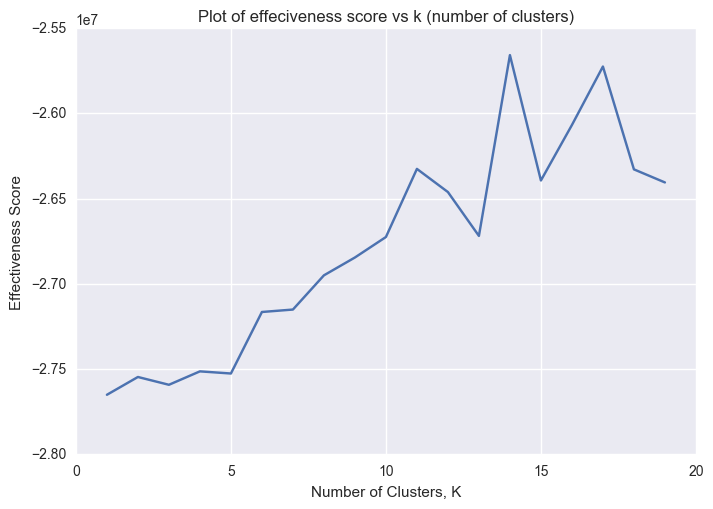

In [10]:
plt.plot(Ks1, score1)
plt.title("Plot of effeciveness score vs k (number of clusters)")
plt.xlabel("Number of Clusters, K")
plt.ylabel("Effectiveness Score")
plt.show()

In [ ]:
# From the elbow plot, it is evident that there is no proper trend in variation of effectiveness score
# with number of cluster. This is probably beacuse of the use 134 variables (Use of too may variables 
# in k-means clustering might result in noisy results)

In [ ]:
##Clustering on the activity of the customers

In [3]:
priororders = pd.read_csv("order_products__prior.csv")
orders = pd.read_csv("orders.csv")

a = list(orders['order_hour_of_day'])

#Function to create buckets for time of the day
def bucket(a):
    if 0<=a<5:
        return 1
    elif 5<=a<9:
        return 2
    elif 9<=a<12:
        return 3
    elif 12<=a<15:
        return 4
    elif 15<=a<18:
        return 5
    elif 18<=a<21:
        return 6
    elif 21<=a<=24:
        return 7



orders['order_hour_of_day'] = list(map(bucket, a))


# Pivoting hour of the day column to create a column for each bucket and summarising average number 
# of orders by a customer during each bucket
hour = orders[['user_id', 'order_id', 'order_hour_of_day']]
hour = pd.DataFrame(hour.pivot_table(hour, index = 'user_id', columns = 'order_hour_of_day', aggfunc = lambda x: len(x.unique())))
hour = hour.fillna(value = 0)

# Pivoting day of the week and summarising average number of orders by a customer during any particular
# day of the week
day = orders[['user_id', 'order_id', 'order_dow']]
day = pd.DataFrame(day.pivot_table(day, index = 'user_id', columns = 'order_dow', aggfunc = lambda x: len(x.unique())))
day = day.fillna(0)

# Column representing number of orders per customer
norders = pd.DataFrame(orders[['user_id', 'order_number']].groupby('user_id', as_index = False).order_number.max())

# Column representing average number of days between orders for a customer
days = orders[orders.order_number!=1]
days = pd.DataFrame(days[['user_id','days_since_prior_order']].groupby('user_id', as_index = False).mean())



hour.columns = range(1,8)
hour = add_to_columnnames(hour, "time_of_day_")

day.columns = range(1,8)
day = add_to_columnnames(day, "day_of_week_")

norders.set_index('user_id', inplace = True)

days.set_index('user_id', inplace = True)

cust_summ_times = days.join(hour, how = 'left').join(day, how = 'left').join(norders, how = 'left')
cust_summ_times.to_csv("cust_summ_times.csv")




In [16]:
X = pd.read_csv("cust_summ_times.csv")
X.set_index('user_id', inplace = True)
X = np.matrix(X)
X =sklearn.preprocessing.scale(X, axis=0, with_mean=True, with_std=True, copy=False)


Ks = range(1, 30)
km = [MiniBatchKMeans(init='k-means++', n_clusters=i,n_init=10000, max_no_improvement=10, verbose=0) for i in Ks]
score = [km[i].fit(X).score(X) for i in range(len(km))]

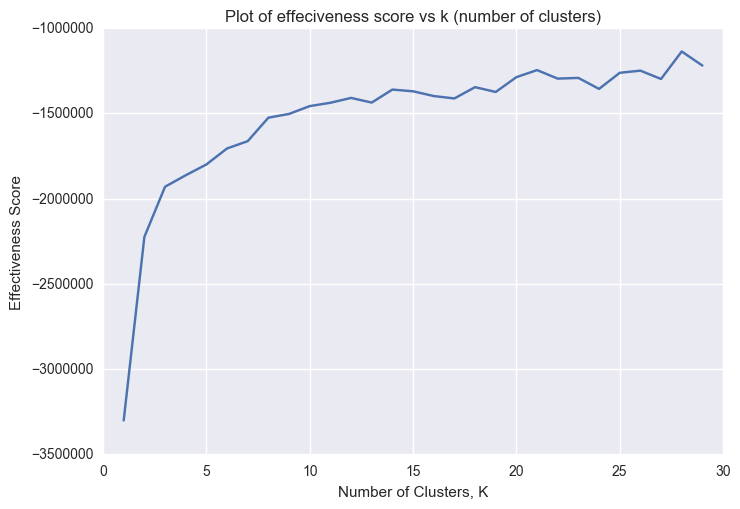

In [17]:
plt.plot(Ks, score)
plt.title("Plot of effeciveness score vs k (number of clusters)")
plt.xlabel("Number of Clusters, K")
plt.ylabel("Effectiveness Score")
plt.show()

In [ ]:
#K-means clustering with k = 4 as found from the above elbow plot
km = MiniBatchKMeans(init='k-means++', n_clusters=5,n_init=100000, max_no_improvement=10, verbose=0)
km.fit(X)
y = km.predict(X)

with open('timecluters1.pickle', 'wb') as handle:
    pickle.dump(y, handle, protocol=pickle.HIGHEST_PROTOCOL)
